In [2]:
!pip install gym

     |████████████████████████████████| 1.6MB 1.5MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/1c/fc/dad5eaaab68f0c21e2f906a94ddb98175662cc5a654eee404d59554ce0fa/pyglet-1.3.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/90/52/e20466b85000a181e1e144fd8305caf2cf475e2f9674e797b222f8105f5f/future-0.17.1.tar.gz
  Created wheel for gym: filename=gym-0.14.0-cp37-none-any.whl size=1637526 sha256=8ec89bed012210e268189bef254a1fa86d1aa187685a5add8acc5fac19b8354d
  Stored in directory: /home/kevin/.cache/pip/wheels/7e/53/f6/c0cd3c9bf953f35c0aee7fa62ea209371e92f5e5cced3245ba
  Created wheel for future: filename=future-0.17.1-cp37-none-any.whl size=488730 sha256=fdf5aea76a1ef8ecae79760f976b9c55d13dddb08cb2f4a199ced16471ab9f06
  Stored in directory: /home/kevin/.cache/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
Successfully built gym future


In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

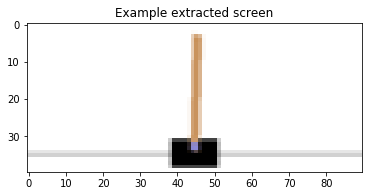

In [4]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()


In [5]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [6]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [9]:
num_episodes = 500
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

<Figure size 432x288 with 0 Axes>

Complete


<Figure size 432x288 with 0 Axes>

In [10]:
reward

tensor([1.])

In [4]:
import time
import gym
try:
    env
except: 
    env = None
if env:
    env.close()
env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env.reset()
last_screen = get_screen()
current_screen = get_screen()
state = current_screen - last_screen
for i in range(300):
    env.render()
    time.sleep(0.1)
    # Select and perform an action
    action = select_action(state)
    _, reward, done, _ = env.step(action.item())
    
    print("i: {} reward {}".format(i, reward))
    reward = torch.tensor([reward], device=device)

    # Observe new state
    last_screen = current_screen
    current_screen = get_screen()
    
    if done:
        print("DONE")
        break
    next_state = current_screen - last_screen

    # Move to the next state
    state = next_state


NameError: name 'matplotlib' is not defined

In [36]:
from sklearn.datasets import load_sample_images
from skimage.viewer import ImageViewer
from skimage import data, color, io
import numpy as np

# suppress warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


# convolution code derived from 
# http://machinelearninguru.com/computer_vision/basics/convolution/image_convolution_1.html
def convolve(img, kernel):    
    """assume 3x3 kernel shape"""
    # construct an output array of the same size as the input image
    output = np.zeros_like(img)
    
    # create a padded image so that we can convolve through the whole thing, "same" padding
    image_padded = np.zeros((img.shape[0] + kernel.shape[0]-1, img.shape[1]+kernel.shape[1]-1))
    image_padded[1:-1,1:-1] = img
    for x in range(img.shape[1]):
        for y in range(img.shape[0]):
            output[y,x] = (kernel * image_padded[y:y+3,x:x+3]).sum()
    return output

def preprocess(img):
    return color.rgb2gray(img)

astronaut_image = data.astronaut()
gray_img = preprocess(astronaut_image)
# edge detection kernel: 
edge_img = convolve(gray_img, np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]))

io.imsave('astronaut.png',astronaut_image)
io.imsave('astronaut_gray.png',gray_img)
io.imsave('astronaut_edges.png', edge_img)

ValueError: Images of type float must be between -1 and 1.

In [47]:
img = np.array([[1,2,3],[4,5,6],[7,8,9]])
img


array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [48]:
kernel = np.array([[1,0],[0,1]])
kernel

array([[1, 0],
       [0, 1]])

In [50]:
O = np.zeros_like(img)
m = 0
n = 0
for m in range(img.shape[0]):
    for n in range(img.shape[1]):
        for i in range(kernel.shape[0]):
            for j in range(kernel.shape[1]):
                O[i,j] += kernel[i,j] * img[i+m,j+n]
O

IndexError: index 3 is out of bounds for axis 1 with size 3

In [52]:
edge_filter = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
edge_filter

array([[-1, -1, -1],
       [-1,  8, -1],
       [-1, -1, -1]])

In [53]:
I = np.array([[1,1,1],[1,1,1],[1,1,1]])
(I * edge_filter).sum()

0

In [19]:
right_edge_filter = np.flipud(np.fliplr(right_edge_filter))

In [20]:
output = np.zeros_like(astronaut_image)

In [54]:
output.shape

(512, 512, 3)

In [55]:
def conv_output_size(input_dim, padding, stride, kernel_dim):
    P = 1 if padding == 'same' else 0
    return (input_dim - kernel_dim + P*2)/stride + 1
print(conv_output_size(512,'same',1,3))
    

512.0


In [51]:
from skimage import color
gray_image = color.rgb2gray(astronaut_image)

In [33]:
gray_image2 = io.imread('astronaut_gray.bmp')
viewer = ImageViewer(gray_image2)
viewer.show()


FileNotFoundError: [Errno 2] No such file or directory: 'astronaut_gray.bmp'

In [23]:
image_padded = np.zeros((gray_image.shape[0] + 2, gray_image.shape[1]+2))

In [24]:
image_padded[1:-1,1:-1] = gray_image

In [32]:
for x in range(gray_image.shape[1]):
    for y in range(gray_image.shape[0]):
        output[y,x] = (right_edge_filter * image_padded[y:y+3,x:x+3]).sum()
        
io.imsave('astronaut_edges.png', output)
        

/home/kevin/anaconda3/envs/drlnd/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: astronaut_edges.png is a low contrast image
  warn('%s is a low contrast image' % fname)


In [26]:
viewer = ImageViewer(output)

In [27]:
viewer.show()

[]

In [4]:
from skimage.viewer import ImageViewer

ModuleNotFoundError: No module named 'skimage'

In [56]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [1]:
from collections import deque, namedtuple
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [2]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs, seed):
        super(DQN, self).__init__()
        print("h: {} w: {} outputs {}".format(h, w, outputs))
        self.seed = torch.manual_seed(seed)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size, stride):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(w,kernel_size=8,stride=4), kernel_size=4, stride=2)
        convh = conv2d_size_out(conv2d_size_out(h, kernel_size=8, stride=4), 
                                                kernel_size=4, stride=2)
        linear_input_size = convw * convh * 32
        self.fc1 = nn.Linear(linear_input_size, 512)
        self.fc2 = nn.Linear(512, outputs)
        

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        return self.fc2(x)

In [3]:
import random
BATCH_SIZE = 128
BUFFER_SIZE = int(1e5)
TAU = 0.01
GAMMA = 0.99
LR=5e-4
class DQNAgent:
    def __init__(self, height, width, action_size, seed):
        self.seed = random.seed(seed)
        self.action_size = action_size
        self.batch_indices = torch.arange(BATCH_SIZE).long().to(device)
        self.samples_before_learning = 1000
        self.learn_interval = 20
        self.parameter_update_interval = 2
        self.tau = TAU
        self.gamma = GAMMA

        self.qnetwork_local = DQN(height, width, action_size, seed).to(device)
        self.qnetwork_target = DQN(height, width, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        self.t_step = 0
        
    def act(self, state, eps=0.):
    
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        state = state.reshape((1,state.shape[0], state.shape[1], state.shape[2]))
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() < eps:
            return random.choice(np.arange(self.action_size))
        else:
            return np.argmax(action_values.cpu().data.numpy())
        
    def step(self, state, action, reward, next_state, done):
        state = state.reshape((1,1,state.shape[0], state.shape[1]))
        next_state = next_state.reshape((1,1,next_state.shape[0], next_state.shape[1]))
        self.memory.add(state, action, reward, next_state, done)
        self.t_step += 1
        if self.t_step % self.learn_interval == 0:
            if len(self.memory) > self.samples_before_learning:
                #state = torch.from_numpy(state).float().unsqueeze(0).to(device)
                state = torch.from_numpy(state).float().to(device)

                #next_state = torch.from_numpy(next_state).float().unsqueeze(0).to(device)
                next_state = torch.from_numpy(next_state).float().to(device)

                target = self.qnetwork_local(state).data
                old_val = target[0][action]
                target_val = self.qnetwork_target(next_state).data
                if done:
                    target[0][action] = reward
                else:
                    target[0][action] = reward + self.gamma * torch.max(target_val)
                indices=None
                weights=None
                states, actions, rewards, next_states, dones = self.memory.sample()

                self.learn(states, actions, rewards, next_states, dones, indices, weights, self.gamma)
        
    def learn(self, states, actions, rewards, next_states, dones, indices, weights, gamma):
        states = torch.from_numpy(np.vstack(states)).float().to(device)
        actions = torch.from_numpy(np.vstack(actions)).long().to(device)
        rewards = torch.from_numpy(np.vstack(rewards)).float().to(device)
        next_states = torch.from_numpy(np.vstack(next_states)).float().to(device)
        dones = torch.from_numpy(np.vstack(dones)).float().to(device)
        states = states.reshape((BATCH_SIZE, 1, states.shape[1], states.shape[2]))
        next_states = next_states.reshape((BATCH_SIZE, 1, next_states.shape[1], next_states.shape[2]))

        Q_targets_next = self.qnetwork_target(next_states).detach()

        Q_targets_next = Q_targets_next.max(1)[0]

        Q_targets = rewards + gamma * Q_targets_next.reshape((BATCH_SIZE, 1)) * (1 - dones)

        pred = self.qnetwork_local(states)
        Q_expected = pred.gather(1, actions)

        self.optimizer.zero_grad()
        loss = F.mse_loss(Q_expected, Q_targets)
        loss.backward()
        self.optimizer.step()

        if self.t_step % self.parameter_update_interval == 0:
            self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)

    def soft_update(self, qnetwork_local, qnetwork_target, tau):
        for local_param, target_param in zip(qnetwork_local.parameters(), qnetwork_target.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)
    

In [4]:
def to_grayscale(img):
    return np.mean(img, axis=2).astype(np.uint8)

def downsample(img):
    return img[::2, ::2]

def preprocess(img):
    return to_grayscale(downsample(img))

In [5]:



env = gym.make('BreakoutDeterministic-v4')
action_size = env.action_space.n
state = env.reset()
height, width = preprocess(state).shape
EPS_DECAY  = 0.99995
EPS_MIN = 0.1

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_episodes = 2500
agent = DQNAgent(height, width, action_size, 0)

scores = []
eps = 1.0
for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    state = preprocess(state)
    score = 0
    steps = 0
    while True:
        # Select and perform an action
        action = agent.act(state, eps)
        next_state, reward, done, _ = env.step(action.item())
        next_state = preprocess(next_state)
        reward = torch.tensor([reward], device=device)

        agent.step(state, action, reward, next_state, done)
        
        score += reward.cpu()[0]
        # Move to the next state
        state = next_state
        eps *= EPS_DECAY
        eps = max(eps, EPS_MIN)

        steps += 1
        if done:
            break
            
    scores.append(score)
    last10_mean = 0.
    if i_episode > 10:
        last10_mean = np.mean(scores[i_episode-10:])
    print("\rGame {:3d} Score {:.3f} completed in {:5d} steps eps {:.3f} last 10 avg {:.3f}".format(
        i_episode, score, steps, eps, last10_mean), end="")
    if i_episode % 10 == 0:
        print()

h: 105 w: 80 outputs 4
h: 105 w: 80 outputs 4
Game   0 Score 1.000 completed in   175 steps eps 0.991 last 10 avg 0.000
Game  10 Score 0.000 completed in   129 steps eps 0.897 last 10 avg 0.000
Game  20 Score 0.000 completed in   131 steps eps 0.817 last 10 avg 1.091
Game  30 Score 1.000 completed in   158 steps eps 0.749 last 10 avg 1.000
Game  40 Score 0.000 completed in   140 steps eps 0.685 last 10 avg 1.000
Game  50 Score 7.000 completed in   401 steps eps 0.615 last 10 avg 1.909
Game  60 Score 0.000 completed in   154 steps eps 0.563 last 10 avg 1.455
Game  70 Score 0.000 completed in   124 steps eps 0.518 last 10 avg 0.727
Game  80 Score 0.000 completed in   153 steps eps 0.480 last 10 avg 0.545
Game  90 Score 0.000 completed in   145 steps eps 0.443 last 10 avg 0.455
Game 100 Score 1.000 completed in   225 steps eps 0.404 last 10 avg 1.182
Game 110 Score 1.000 completed in   195 steps eps 0.371 last 10 avg 0.909
Game 120 Score 2.000 completed in   201 steps eps 0.340 last 10 av

Game 1090 Score 7.000 completed in   360 steps eps 0.100 last 10 avg 4.9092
Game 1100 Score 2.000 completed in   182 steps eps 0.100 last 10 avg 5.000
Game 1110 Score 9.000 completed in   448 steps eps 0.100 last 10 avg 3.909
Game 1120 Score 5.000 completed in   365 steps eps 0.100 last 10 avg 3.455
Game 1130 Score 2.000 completed in   220 steps eps 0.100 last 10 avg 4.364
Game 1140 Score 4.000 completed in   268 steps eps 0.100 last 10 avg 4.636
Game 1150 Score 3.000 completed in   250 steps eps 0.100 last 10 avg 4.545
Game 1160 Score 7.000 completed in   398 steps eps 0.100 last 10 avg 4.364
Game 1170 Score 7.000 completed in   411 steps eps 0.100 last 10 avg 4.909
Game 1180 Score 9.000 completed in   425 steps eps 0.100 last 10 avg 5.818
Game 1190 Score 3.000 completed in   295 steps eps 0.100 last 10 avg 5.545
Game 1200 Score 4.000 completed in   292 steps eps 0.100 last 10 avg 3.909
Game 1210 Score 5.000 completed in   379 steps eps 0.100 last 10 avg 5.0916
Game 1220 Score 7.000 c

Game 2170 Score 4.000 completed in   333 steps eps 0.100 last 10 avg 5.182
Game 2180 Score 7.000 completed in   418 steps eps 0.100 last 10 avg 4.909
Game 2190 Score 8.000 completed in   295 steps eps 0.100 last 10 avg 5.9092
Game 2200 Score 3.000 completed in   214 steps eps 0.100 last 10 avg 4.818
Game 2210 Score 4.000 completed in   238 steps eps 0.100 last 10 avg 3.909
Game 2220 Score 8.000 completed in   412 steps eps 0.100 last 10 avg 6.8185
Game 2230 Score 4.000 completed in   366 steps eps 0.100 last 10 avg 4.727
Game 2240 Score 5.000 completed in   307 steps eps 0.100 last 10 avg 4.273
Game 2250 Score 2.000 completed in   251 steps eps 0.100 last 10 avg 2.818
Game 2260 Score 4.000 completed in   330 steps eps 0.100 last 10 avg 3.545
Game 2270 Score 3.000 completed in   395 steps eps 0.100 last 10 avg 6.1821
Game 2280 Score 4.000 completed in   260 steps eps 0.100 last 10 avg 5.091
Game 2290 Score 4.000 completed in   319 steps eps 0.100 last 10 avg 3.727
Game 2300 Score 5.000 

In [6]:
import torch
v=torch.LongTensor([1])
print("{:3d}".format(v[0]))

  1
